In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from tcn import TCN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

##
# It's a very naive (toy) example to show how to do time series forecasting.
# - There are no training-testing sets here. Everything is training set for simplicity.
# - There is no input/output normalization.
# - The model is simple.
##

In [45]:
ts = pd.read_csv('./sample_data/monthly-milk-production-pounds-p.csv', index_col=0, parse_dates=True)

print(ts.head())

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727


In [46]:
batch_size = 12  # months.

ts = ts.values  # just keep np array here for simplicity.
scaler = StandardScaler()
ts_norm = scaler.fit_transform(ts)

In [52]:
test_size

24

In [47]:
test_size = batch_size*2
test_start = int(len(ts) - test_size)

In [48]:
ts_train = ts_norm[:test_start]
ts_test = ts_norm[test_start:]

In [50]:
# 1-step-ahead forecast
x_train, y_train = [], []
x_test, y_test = [], []
for i in range(batch_size, len(ts_train)):
    x_train.append(ts_train[(i - batch_size):i])
    y_train.append(ts_train[i])
    
for i in range(batch_size, len(ts_test)): 
    x_test.append(ts_test[(i - batch_size):i])
    y_test.append(ts_test[i])
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [51]:
print(x_train.shape)
print(y_train.shape)
print()
print(x_test.shape)
print(y_test.shape)

(132, 12, 1)
(132, 1)

(12, 12, 1)
(12, 1)


In [37]:
# noinspection PyArgumentEqualDefault
model = Sequential([
    TCN(input_shape=(batch_size, 1),
        dilations = [3,4],
        kernel_size=3,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(1, activation='linear') # https://keras.io/api/layers/activations/
])

model.summary()
model.compile('adam', 'mae')

print('Train...')
model.fit(x_test, y_test, epochs=100, verbose=0)



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_6 (TCN)                 (None, 64)                37440     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,505
Trainable params: 37,505
Non-trainable params: 0
_________________________________________________________________
Train...
4/4 [==============================] - 0s 4ms/step


In [55]:
p_train = model.predict(x_train)
p_test = model.predict(x_test)

1/1 [==============================] - 0s 23ms/step


In [78]:
y_test_units = scaler.inverse_transform(y_test)
p_test_units = np.round(scaler.inverse_transform(p_test),0)

mape = mean_absolute_percentage_error(y_test_units, p_test_units) 

print(" MAPE is: " , np.round(mape, 2)*100, "% for one step ahead forecast" )

 MAPE is:  2.0 % for one step ahead forecast


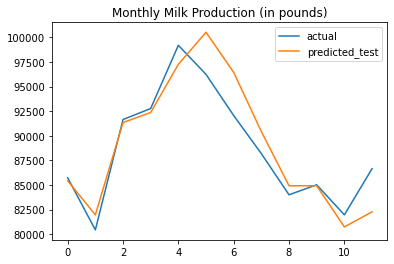

In [79]:
#plt.plot(p)
#plt.plot(y)
#plt.plot(scaler.inverse_transform(p_train))
plt.plot(scaler.inverse_transform(y_test_units))

plt.plot(scaler.inverse_transform(p_test_units))

plt.title('Monthly Milk Production (in pounds)')
plt.legend(['actual', 'predicted_test'])
plt.show()

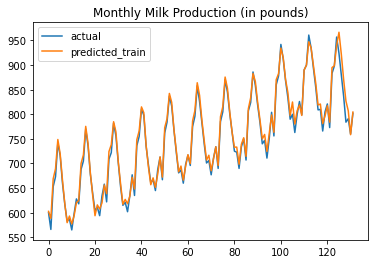

In [80]:
plt.plot(scaler.inverse_transform(y_train))
plt.plot(scaler.inverse_transform(p_train))

plt.title('Monthly Milk Production (in pounds)')
plt.legend(['actual', 'predicted_train'])
plt.show()